# Writing poems Shakespeare-style using a language model with limited depth

## Step 1: Introduction


### The problem

In my in-law's family, we have a tradition for Christmas. Each of us is to write a poem that will be used by the gift receiver to identify the person who gave it. The writer is to leave in the poem enough cues for the receiver to guess, but not say their name. 

Although most of us may enjoy writing poems, for my brother-in-law, it is a chore. So, I have decided to use what was learned in this course to build a small language model that would generate a poem for him, or rather, almost all the poem, provided he puts enough cues about himself in the prompt. 

Note that Shakespeare-style text generation has been done with a network using a single Gated Recurrent Unit network [1]. With the current work, I wanted to improve on this model, as under the hood, it makes use of gradient clipping to deal with exploding gradients. If you attempt to run the model described in [1] with a legacy optimizer that does not use gradient clipping with long sequences, the loss will suddenly jump up and training will fail, due to gradient explosion. Specifically, I wanted to build a model with a depth small enough to be handled by a legacy optimizer.

So rather than simply building a language model for my brother-in-law to write his poem, which has been done by [1], I wanted to find a way to do it without the infinite depth of gradient backpropagation that comes with using Gated Recurrent Units [2] whereby the last output serves as the initial state for the next batch as in [1]. Unlike the forward pass which includes non-linearities, the backward propagation of gradients is purely linear. With each layer, gradients get multiplied by the weight matrix of the layer. With recurrent networks, the recurrent weight matrix is the same as gradients get backpropagated in time. This means gradients are muliplied by the same matrix raised to an infinite power. If a diagonal element is above 1, it leads to gradient explosion. If it is below 1, it leads to vanishing gradients.

Using a classical encoder-decoder architecture design, also used in large Transformers [3], I kept a GRU for decoding, but changed the encoder as to make it shallower, starting with an initial state of zeros whereby gradient backpropagation stops. The results were generally good as long as the encoder included GRUs. It was possible to generate a poem for my brother-in-law keeping the encoder not too deep and recycling the already predicted text as the prompt, using short sequences.

### A few words about language models

Language models are deep neural networks that generate text given a prompt. ChatGPT is probably the most famous one. Use cases include language translation, writing essays, writing code etc... The large language models are word based. The models generate feature vectors that are then converted by a gigantic softmax into word codes. Given the number of words in the English language, this categorical prediction task has to deal with a huge number of categories: the entirity of the English vocabulary. For this reason, this work is not word based. It is character based. In the entire Shakespeare work, there are only 65 different characters, a reasonable number of categories. 

A classical architecture in language models is the encoder-decoder one. The prompt is encoded into a latent vector or matrix, which is passed to the decoder as a representation used to generate text. The decoder output is conditional on this latent representation, but also on the already predicted sequence of words or characters. The decoder generates one word or character after the other. The work presented here follows this general architecture: what is passed from encoder to decoder is the initial state vector of the decoding GRU: it has the dimension of GRU layer. During decoding, some units will keep this information available to decode the end of the decoded sequence, while others more concerned with decoding the begining may alter it. So my goal was to find an encoder that would provide to the decoder a latent representation that would contain the necessary information to decode correctly. 

During training, both the sequence to encode and the ground truth about the decoded sequence are presented to the network. During generation, only the prompt is.

### Choice of metric

In addition to accuracy on a randomly drawn validation subset not used for training, we use a much simpler metric. Given a standard prompt, at the end of training, if the text generated is made of English words, the training is considered successful. If it is made of non-words, it is a failure.

### Data source

The data comes from Andrej Karpathy [4]. He also includes there a lot of interesting information about recurrent neural networks.

### Organization of this notebook

The first part of this notebook, this introduction, is devoted to the definition of the problem we attempt to solve: find an encoder shallow enough to prevent exploding gradients and deliver to the decoder a latent representation allowing it to generate English words. In this first part, we also present the data. In the second part we perform exploratory data analysis. In the third part, we present the model iterations with different design choices (hyperparameters). In the fourth part, we recapitulate the results. In the fifth part, we conclude. 

### Data overview


In [1]:
from __future__ import absolute_import, unicode_literals

import tensorflow as tf
import keras.utils
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [2]:
path_to_file = "tmp/shakespeare.txt"
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

How many characters are there in the entire book of Shakespeare's work?

In [3]:
print('The text is '+str(len(text))+' characters-long')

The text is 1115394 characters-long


What does a snipet of text look like?

In [4]:
print('\nHere is a snipet:\n"'+text[:250]+'"')


Here is a snipet:
"First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.
"


## Step 2: exploratory data analysis

#### Data exploration

Let's first get a list of unique characters in the file, using set(text), then rank them according to utf-8 code

In [5]:
vocabulary = sorted(set(text))
print('There are '+str(len(vocabulary))+' unique characters used in this text. Very few!')

There are 65 unique characters used in this text. Very few!


What are these characters?

In [6]:
char_set=repr(''.join(vocabulary[0]))
for char in vocabulary[1:]:
    char_set=char_set+', '+repr(''.join(char))
print(char_set)

'\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'


Let's look at how often they appear in the text. To do so, though, we need to first create a dictionary giving the vocabulary index given the character and the opposite: a numpy array giving the character given its vocabulary index. Then we will convert the entire text into a long numpy array of integers.

First the dictionary with the character c as the key and the index value i in the vocabulary

In [7]:
idxGivenChar = {c:i for i, c in enumerate(vocabulary)}

Then the other way around: an array of characters giving the character using the index in the vocabulary

In [8]:
charGivenIdx = np.array(vocabulary)

Finally transform the whole text into vocabulary index integers rather than utf-8 characters

In [9]:
text_as_int = np.array([idxGivenChar[c] for c in text])
print('The text snippet: "'+str(text[:13])+'" becomes: '+str(text_as_int[:13]))

The text snippet: "First Citizen" becomes: [18 47 56 57 58  1 15 47 58 47 64 43 52]


Now we can count the number of times each character appears in the text

In [10]:
char_counts=np.zeros([len(vocabulary)],np.int64)
for char_as_int in text_as_int:
    char_counts[char_as_int]+=1
print(char_counts)

[ 40000 169892   2172      1      3   6187  19846   1897   7885     27
  10316   3628   2462   7819   2761   3820   2089   6041   1797   2399
   3068  11832    320   1584   3876   2840   5079   5481   1641    231
   4869   4523   7015   3313    798   3530    112   1718    198  55507
  11321  15623  31358  94611  15770  13356  51310  45537    628   7088
  33339  22243  48529  65798  10808    609  48889  49696  67009  26584
   7793  17585    529  20448    356]


Or, on a histogram:

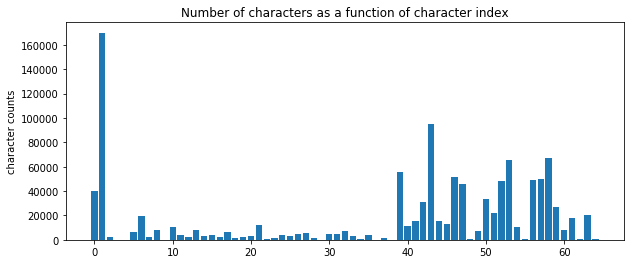

In [11]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
ax.bar(list(range(len(char_counts))),char_counts)
ax.set_ylabel('character counts')
ax.set_title('Number of characters as a function of character index')
plt.show()

Some of these are very rare

In [12]:
print(repr(charGivenIdx[3])+' '+str(char_counts[3])+', '+repr(charGivenIdx[4])+' '+str(char_counts[4])+', '
     +repr(charGivenIdx[9])+' '+str(char_counts[9])+', '+repr(charGivenIdx[36])+' '+str(char_counts[36])+', ')

'$' 1, '&' 3, '3' 27, 'X' 112, 


#### Data cleaning

It would be tempting, if for example the dollar or the ampersand characters were in the end of the text, to get rid of this portion, but they are not:

In [13]:
for position in range(len(text)):
    if text[position]=='$':
        print('Dollar is found at position: '+str(position))
    if text[position]=='&':
        print('Ampersand is found at position: '+str(position))
print('The last character has position: '+str(len(text)-1))

Ampersand is found at position: 75323
Ampersand is found at position: 75671
Ampersand is found at position: 683321
Dollar is found at position: 686615
The last character has position: 1115393


So there is no cleaning to do.

## Step 3: model iterations

#### Data processing into sequences

For this work, we will set the encoder and the decoder sequence lengths both at 10 characters. So for training and inference, the encoder will need 10 characters of input sequence. For training only, the decoder will need the next 10 characters.

In [86]:
seq_length=10

However, as a decoder, we use a GRU, with the parameter "return_sequences" set to True. What this means is that at each time step, the GRU will generate a prediction for the next character in the sequence, and, during training, the gradient will be computed by comparing with the ground truth: the actual next character. So for the whole input sequence, for training purposes, we also need a sequence of next characters, which is the input sequence minus the first input character plus the character following the last input character. In other words, the same sequence shifted by one position.

So we will chop the data into text snippets of length 2 sequence lengths plus 1, from which we can extract the various sequences needed for the encoder and decoder.

In [87]:
snippet_length=2*seq_length+1

So if we chop the text into sequences of length 21, it creates as many samples as we can extract from the data:

In [88]:
n_samples_per_epoch = len(text)//snippet_length
print(n_samples_per_epoch)

53114


Let's get chop the text into sequences of length 21:

In [89]:
sequences = np.array([text_as_int[idx*snippet_length:(idx+1)*snippet_length] for idx in range(n_samples_per_epoch)])

Depending on the batch size, we may or may not use all theses, so let's set the batch size and see how many batches we can extract from the data

In [90]:
batch_size = 64
n_batches_per_epoch=n_samples_per_epoch//batch_size
print(n_batches_per_epoch)

829


Now we know the number of batches we fit in an epoch, we can calculate the number of samples we actually use.

In [91]:
n_usable_samples=n_batches_per_epoch*batch_size
print(n_usable_samples)

53056


Then split the sample sequences into input and labels:

In [92]:
def split_input_target(snippet):
    input_text = snippet[:,:-1]
    target_text = snippet[:,1:]
    return input_text, target_text

input_data, target_data = split_input_target(sequences[:n_usable_samples])
print(input_data.shape, target_data.shape)

(53056, 20) (53056, 20)


Shuffling the data and separate it into a training set and a validation set will be done by the fit method.

In [93]:
n_batches_per_epoch//10
validation_split=(n_batches_per_epoch//10)/n_batches_per_epoch
print(validation_split)

0.09891435464414958


Using the "charGivenIdx" mapping array, we can translate these inputs and labels into plain text:

In [94]:
rd=np.int32(n_samples_per_epoch*np.random.rand())
print('Input data:')
print (''.join(charGivenIdx[input_data[rd]]))
print('\nTarget data:')
print (''.join(charGivenIdx[target_data[rd]]))

Input data:
 'head below his kne

Target data:
'head below his knee


#### Model iteration 1: the encoder is a convolutional network

As a first attempt, we will try to use a convolutional network to encode the encoder sequence into a representation fo the initial state fed to the decoding GRU

In [95]:
# Hyperparameters:

# Length of the vocabulary in chars
vocab_size = len(vocabulary)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

However, since we are also using instance normalization layers and my keras implementation does not include this object, we need to implement our own.

In [96]:
class MyInstanceNormalizationVersion(tf.keras.layers.Layer):
    def __init__(self,epsilon=1e-3):
        super().__init__()
        self.epsilon=epsilon
        
    def call(self,inputs):
        instance_mean=tf.reshape(tf.reduce_mean(tf.reduce_mean(inputs,axis=2),axis=1),[-1,1,1])
        instance_var=tf.reduce_mean(tf.reduce_mean((inputs-instance_mean)**2,axis=2),axis=1)
        instance_std_dev=tf.reshape(tf.sqrt(instance_var),[-1,1,1])
        return (inputs-instance_mean)/(instance_std_dev+self.epsilon)

In [97]:
encoder_seq_inputs=tf.keras.Input(batch_shape=(batch_size,seq_length))
decoder_seq_inputs=tf.keras.Input(batch_shape=(batch_size,seq_length))
x1=tf.keras.layers.Embedding(vocab_size,embedding_dim,batch_size=batch_size)(encoder_seq_inputs)
#yields batch_size by seq_length by embedding_dim
x2=tf.keras.layers.Embedding(vocab_size,embedding_dim,batch_size=batch_size)(decoder_seq_inputs)
#yields batch_size by seq_length by embedding_dim
x3=tf.keras.layers.Conv1D(256,kernel_size=5,use_bias=False)(x2)
#yields batch_size by (seq_length -5 + 1=6) by 256
x3=tf.keras.layers.LeakyReLU(alpha=0.2)(x3)
x3=MyInstanceNormalizationVersion()(x3)
x3=tf.keras.layers.Conv1D(512,kernel_size=3, use_bias=False)(x3)
#yields batch_size by (6-3+1 =4) by 512
x3=tf.keras.layers.LeakyReLU(alpha=0.2)(x3)
x3=MyInstanceNormalizationVersion()(x3)
x4=tf.keras.layers.Conv1D(filters=rnn_units,kernel_size=4, use_bias=False,activation='tanh')(x3)
#yields batch_size by 1 by rnn_units
x4r=tf.keras.layers.Reshape(target_shape=(rnn_units,))(x4)
#yields batch_size by rnn_units
x5=tf.keras.layers.GRU(rnn_units,return_sequences=True,stateful=False,
                                               recurrent_initializer='glorot_uniform')([x2,x4r])
x6=tf.keras.layers.Concatenate(axis=1)([x4,x5])
outputs=tf.keras.layers.Dense(vocab_size, activation ='softmax')(x6)
model1=tf.keras.Model(inputs=[encoder_seq_inputs,decoder_seq_inputs],outputs=outputs)
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (64, 10)             0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (64, 10, 256)        16640       input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (64, 6, 256)         327680      embedding_12[0][0]               
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (64, 6, 256)         0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
my_instanc

This large network deserves a little explanation.

First, the encoder input sequence gets translated into a sequence of embedding vectors. The decoder input sequence also gets translated into a sequence of embedding vectors, but it will be used later.

Second, the translated encoder sequence is interpreted as a 1 D image along the sequence dimension with as many channels as there are embedding dimensions. A series of 3 1 D convolutions with leaky relu activation followed by instance normalization are applied to it. The last convolution is an exception: it has a hyperbolic tangent activation function, in order to match the kind of initial state a GRU gets. The convolution stages decrease the sequence dimension to 1. Here is our latent vector. The latent vector also goes through a dense layer with a softmax activation function, because with GRUs it is also used to predict the next character.

For training, the decoder side uses two inputs: the latent vector and the decoder input sequence, translated into embeddings. 
At each time step, the decoder confronts its category prediction after translation by a dense layer with softmax activation to the ground truth of the next character.

So the inputs to the network consist of the encoder sequence, the decoder sequence, the ground truth for the next character predicted by the encoder and the ground truth sequence for the decoder. The way the last two are fed to the model is as as sequence of 11 characters taken from the target data whose start is one time step earlier.

In [98]:
model1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['acc'])

In [99]:
history1=model1.fit([input_data[:,:seq_length],input_data[:,seq_length:]],
                   keras.utils.to_categorical(target_data[:,seq_length-1:], num_classes=vocab_size),
                   shuffle=True, validation_split=validation_split,
                   batch_size=batch_size, epochs=15) #15

Train on 47808 samples, validate on 5248 samples
Epoch 1/15
47808/47808 [==============================] - 35s 741us/step - loss: 2.4677 - acc: 0.3491 - val_loss: 2.3146 - val_acc: 0.3835
Epoch 2/15
47808/47808 [==============================] - 34s 704us/step - loss: 1.9621 - acc: 0.4297 - val_loss: 2.0294 - val_acc: 0.4154
Epoch 3/15
47808/47808 [==============================] - 34s 705us/step - loss: 1.3310 - acc: 0.6034 - val_loss: 0.8961 - val_acc: 0.7371
Epoch 4/15
47808/47808 [==============================] - 34s 706us/step - loss: 0.5732 - acc: 0.8287 - val_loss: 0.5225 - val_acc: 0.8460
Epoch 5/15
47808/47808 [==============================] - 34s 708us/step - loss: 0.3332 - acc: 0.9000 - val_loss: 0.3677 - val_acc: 0.8937
Epoch 6/15
47808/47808 [==============================] - 34s 708us/step - loss: 0.2473 - acc: 0.9256 - val_loss: 0.3194 - val_acc: 0.9079
Epoch 7/15
47808/47808 [==============================] - 34s 709us/step - loss: 0.2100 - acc: 0.9365 - val_loss: 0.2

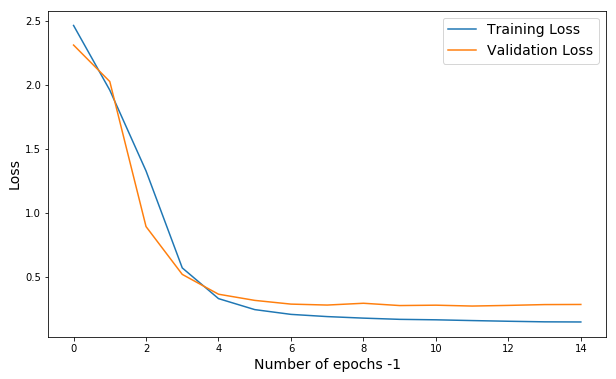

In [100]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(history1.history['loss'],label='Training Loss')
plt.plot(history1.history['val_loss'],label='Validation Loss')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.legend(loc="upper right", fontsize=14)

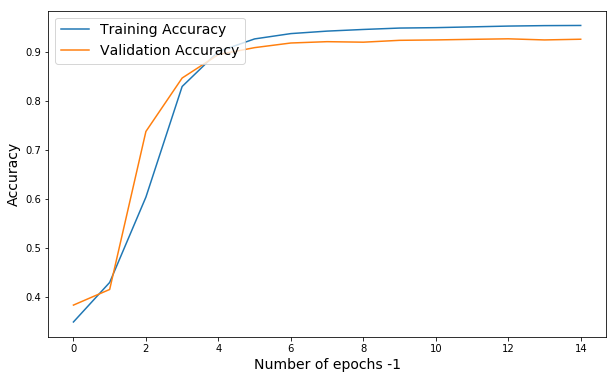

In [101]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(history1.history['acc'],label='Training Accuracy')
plt.plot(history1.history['val_acc'],label='Validation Accuracy')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.legend(loc="upper left", fontsize=14)

The curves looks great. It looks like we should try training longer. (This was done until the curves flatten. It does not change the results).

Let's choose a starter sequence to see what the network will produce:

In [102]:
prompt = "With this "

Intitialize the portion of predicted text with this prompt:

In [103]:
predicted_text = prompt

Tokenize it as an array of indices

In [104]:
prompt_int = np.array([idxGivenChar[c] for c in predicted_text])

Take the place of the last character of the prompt as the start of the predicted following character indices

In [105]:
start_char_int = len(prompt_int)

The model demands we send it a batch of inputs. Just as with push pins: even though you need only one, you have to buy 100. Here too, we get a batch of integers, even though we only need one row of the batch matrix to be set to the prompt. So we get a random batch of intputs we call input_example_batch.

In [106]:
input_example_batch=np.zeros([batch_size,snippet_length-1],np.int32)

First we set the number of text snippets of length (snippet_length-1), we want the network to generate and we iterate for a given number of snippets. We first initialize the first line of the batch with the prompt, which may contain less than seq_length characters. Then we iterate over the number of remaining characters to predict for this snippet: the network outputs a prediction, from which we keep the new character predicted as an integer, given by its position in the sequence. We convert this integer into a character. If it is not character number 20, we simply place it where it belongs in the first line of the batch. If it is 20, we set the start all the characters of the prompt but the last one to the all the characters of the first line of the batch but the first one, then we set the last character of the prompt to the predicted character.
Then we move on to the next snippet, with this new prompt, as if all the characters but the last one had already been decoded.

In [107]:
n_snippets=10
for snippet in range(n_snippets):
    input_example_batch[0,:start_char_int] = prompt_int #we start with char_int = 10 with a prompt of 10 char
    for char_idx in range(start_char_int, snippet_length): # char_idx starts at 10 and ends at 20: 11 numbers
        example_batch_predictions = np.argmax(model1.predict([input_example_batch[:,:seq_length],
                                                              input_example_batch[:,seq_length:]],
                                                              verbose=0,batch_size=batch_size),axis=2)
        predicted_char = example_batch_predictions[0,char_idx-seq_length] #predicted char starts at 0 ends at 10: 11nbs
        predicted_text = predicted_text + charGivenIdx[predicted_char]
        if char_idx <snippet_length-1: #if char_idx is less than 20
            input_example_batch[0,char_idx]= predicted_char
        else: # if char_idx is 20, drop first character of the prompt; 
            prompt_int[:start_char_int-1] = input_example_batch[0,snippet_length-start_char_int:snippet_length-1]
            prompt_int[start_char_int-1] = predicted_char

Here is the result

In [108]:
print(predicted_text)

With this 


ICIV:

A


ICIV:

A


ICIV:

A


ICIV:

A


ICIV:

A


ICIV:

A


ICIV:

A


ICIV:

A


ICIV:

A


ICIV:

A


Oops! Not quite English, or rather an output looking like a broken record playing. Although the training curves were pointing towards much different picture the result is not good. This is likely because accuracy is not the right measure for generating English sentences. Because accuracy destribes the average of character matches in the predicted sequence, when when what matters more is consistency between the characacters generated in forming an English phrase. The probability of characters within a sequence are not independent.

Validation accuracy here is a poor measure of performance.

#### Model iteration 2: the encoder is a GRU that only puts out the final state

So let's backtrack. Perhaps this convolutional network was a bit much over the top. Let's try a GRU again, with the value return_sequences set to False as the goal is to get a single output from the encoder representing the initial state for the decoder.

In [116]:
encoder_seq_inputs=tf.keras.Input(batch_shape=(batch_size,seq_length))
decoder_seq_inputs=tf.keras.Input(batch_shape=(batch_size,seq_length))
x1=tf.keras.layers.Embedding(vocab_size,embedding_dim,batch_size=batch_size)(encoder_seq_inputs)
x2=tf.keras.layers.Embedding(vocab_size,embedding_dim,batch_size=batch_size)(decoder_seq_inputs)
x3=tf.keras.layers.GRU(rnn_units,return_sequences=False,return_state=False,stateful=False,
                                               recurrent_initializer='glorot_uniform')(x1)
x5=tf.keras.layers.GRU(rnn_units,return_sequences=True,stateful=False,
                                               recurrent_initializer='glorot_uniform')([x2,x3])
x4=tf.keras.layers.Reshape(target_shape=(1,rnn_units))(x3)
x6=tf.keras.layers.Concatenate(axis=1)([x4,x5])
outputs=tf.keras.layers.Dense(vocab_size, activation ='softmax')(x6)
model2=tf.keras.Model(inputs=[encoder_seq_inputs,decoder_seq_inputs],outputs=outputs)
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (64, 10)             0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (64, 10, 256)        16640       input_15[0][0]                   
__________________________________________________________________________________________________
input_16 (InputLayer)           (64, 10)             0                                            
__________________________________________________________________________________________________
gru_16 (GRU)                    (64, 1024)           3935232     embedding_15[0][0]               
__________________________________________________________________________________________________
embedding_

In [117]:
model2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['acc'])

In [118]:
history2=model2.fit([input_data[:,:seq_length],input_data[:,seq_length:]],
                    keras.utils.to_categorical(target_data[:,seq_length-1:], num_classes=vocab_size),
                    shuffle=True, validation_split=validation_split,
                    batch_size=batch_size, epochs=10) #10

Train on 47808 samples, validate on 5248 samples
Epoch 1/10
47808/47808 [==============================] - 58s 1ms/step - loss: 2.0496 - acc: 0.4079 - val_loss: 1.8536 - val_acc: 0.4542
Epoch 2/10
47808/47808 [==============================] - 56s 1ms/step - loss: 1.6369 - acc: 0.5079 - val_loss: 1.7347 - val_acc: 0.4901
Epoch 3/10
47808/47808 [==============================] - 56s 1ms/step - loss: 1.4982 - acc: 0.5436 - val_loss: 1.6747 - val_acc: 0.5077
Epoch 4/10
47808/47808 [==============================] - 56s 1ms/step - loss: 1.4007 - acc: 0.5683 - val_loss: 1.6755 - val_acc: 0.5080
Epoch 5/10
47808/47808 [==============================] - 56s 1ms/step - loss: 1.3166 - acc: 0.5896 - val_loss: 1.6809 - val_acc: 0.5118
Epoch 6/10
47808/47808 [==============================] - 56s 1ms/step - loss: 1.2316 - acc: 0.6122 - val_loss: 1.7180 - val_acc: 0.5073
Epoch 7/10
47808/47808 [==============================] - 56s 1ms/step - loss: 1.1453 - acc: 0.6355 - val_loss: 1.7776 - val_acc:

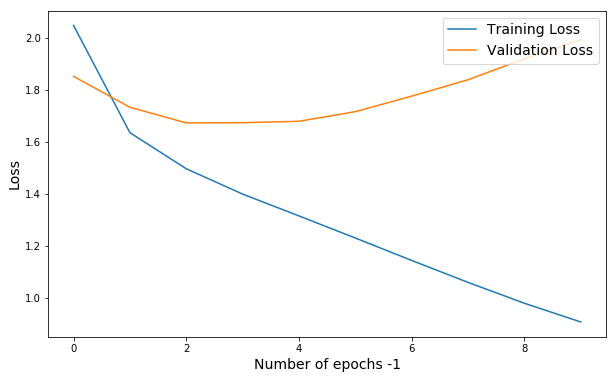

In [119]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(history2.history['loss'],label='Training Loss')
plt.plot(history2.history['val_loss'],label='Validation Loss')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.legend(loc="upper right", fontsize=14)

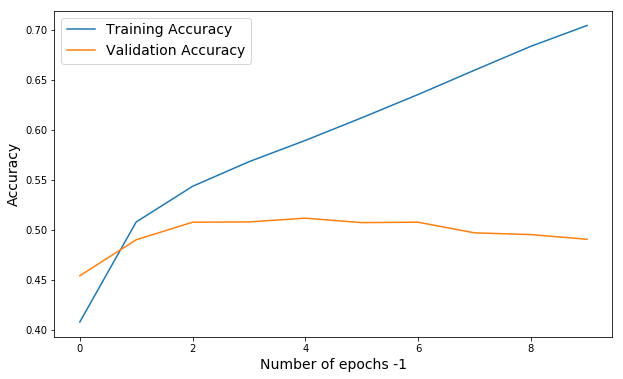

In [120]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(history2.history['acc'],label='Training Accuracy')
plt.plot(history2.history['val_acc'],label='Validation Accuracy')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.legend(loc="upper left", fontsize=14)

In [121]:
n_snippets=100
prompt = "With this "
predicted_text = prompt
prompt_int = np.array([idxGivenChar[c] for c in predicted_text])
start_char_int = len(prompt_int)
input_example_batch=np.zeros([batch_size,snippet_length-1],np.int32)
for snippet in range(n_snippets):
    input_example_batch[0,:start_char_int] = prompt_int #we start with char_int = 10 with a prompt of 10 char
    for char_idx in range(start_char_int, snippet_length): # char_idx starts at 10 and ends at 20: 11 numbers
        example_batch_predictions = np.argmax(model2.predict([input_example_batch[:,:seq_length],
                                                              input_example_batch[:,seq_length:]],
                                                              verbose=0,batch_size=batch_size),axis=2)
        predicted_char = example_batch_predictions[0,char_idx-seq_length] #predicted char starts at 0 ends at 10: 11nbs
        predicted_text = predicted_text + charGivenIdx[predicted_char]
        if char_idx <snippet_length-1: #if char_idx is less than 20
            input_example_batch[0,char_idx]= predicted_char
        else: # if char_idx is 20, drop first character of the prompt; 
            prompt_int[:start_char_int-1] = input_example_batch[0,snippet_length-start_char_int:snippet_length-1]
            prompt_int[start_char_int-1] = predicted_char

In [122]:
print(predicted_text)

With this mark made a shameful beaus in me to acquainted to spiries than he had pone is thine.

QUEEN MARGARET:
O prince, and I for him.

LUCIO:
'Tis he, sir, but the painter leisurely fair an apparetel souls of me and put upon this fair come.

FRIAR LAUREY:
That you might a poison ot a life,
And I'll find the fight of a queen of his death.
If I had not a man that he counds the worst than a former days love to speak.

CLIFFORD:
Ay, ay, as thou art how to be ill-bed, where you shear, friends, sir, say that the mad boys will be pardon me to the same to the prince my father.
But in this rosom of the seads and my sons should be the man cannot shall be the consul's honour,
If I say for the desire to come to show 'twas the ward of my sons should be the man cannot shall be the consul's honour,
If I say for the desire to come to show 'twas the ward of my sons should be the man cannot shall be the consul's honour,
If I say for the desire to come to show 'twas the ward of my sons should be the m

Much better. I think we can call this English. It looks as if the model starts to overfit after the third epoch. Actually, if one tries to only train for 3 epochs, the ability for the model to generate an output that is English is worse. Most likely because validation accuracy and validation loss are not adequate measures of the model's performance. 

#### Model iteration 3: the encoder is a GRU that puts out all the states of the sequence.

Now, we set the parameter return_sequences, which requires the provision of the labels for the input sequence too, with the parameter stateful to False, which prevents the encoder from using an informative initial state. If we set the parameter stateful to True, the model would be equivalent to [1]

In [63]:
encoder_seq_inputs=tf.keras.Input(batch_shape=(batch_size,seq_length))
decoder_seq_inputs=tf.keras.Input(batch_shape=(batch_size,seq_length))
x1=tf.keras.layers.Embedding(vocab_size,embedding_dim,batch_size=batch_size)(encoder_seq_inputs)
x2=tf.keras.layers.Embedding(vocab_size,embedding_dim,batch_size=batch_size)(decoder_seq_inputs)
[x3,x4]=tf.keras.layers.GRU(rnn_units,return_sequences=True,return_state=True,stateful=False,
                                               recurrent_initializer='glorot_uniform')(x1)
x5=tf.keras.layers.GRU(rnn_units,return_sequences=True,stateful=False,
                                               recurrent_initializer='glorot_uniform')([x2,x4])
x6=tf.keras.layers.Concatenate(axis=1)([x3,x5])
outputs=tf.keras.layers.Dense(vocab_size, activation ='softmax')(x6)
model3=tf.keras.Model(inputs=[encoder_seq_inputs,decoder_seq_inputs],outputs=outputs)
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (64, 10)             0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (64, 10, 256)        16640       input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            (64, 10)             0                                            
__________________________________________________________________________________________________
gru_5 (GRU)                     [(64, 10, 1024), (64 3935232     embedding_7[0][0]                
__________________________________________________________________________________________________
embedding_

In [64]:
model3.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['acc'])

In [65]:
history3=model3.fit([input_data[:,:seq_length],input_data[:,seq_length:]],
                    keras.utils.to_categorical(target_data, num_classes=vocab_size),
                    shuffle=True, validation_split=validation_split,
                    batch_size=batch_size, epochs=3) #12

Train on 47808 samples, validate on 5248 samples
Epoch 1/12
47808/47808 [==============================] - 57s 1ms/step - loss: 2.0670 - acc: 0.4007 - val_loss: 1.7837 - val_acc: 0.4681
Epoch 2/12
47808/47808 [==============================] - 56s 1ms/step - loss: 1.6904 - acc: 0.4910 - val_loss: 1.6516 - val_acc: 0.5028
Epoch 3/12
47808/47808 [==============================] - 56s 1ms/step - loss: 1.5715 - acc: 0.5210 - val_loss: 1.6060 - val_acc: 0.5136
Epoch 4/12
47808/47808 [==============================] - 56s 1ms/step - loss: 1.4920 - acc: 0.5411 - val_loss: 1.5958 - val_acc: 0.5168
Epoch 5/12
47808/47808 [==============================] - 56s 1ms/step - loss: 1.4246 - acc: 0.5583 - val_loss: 1.6000 - val_acc: 0.5206
Epoch 6/12
47808/47808 [==============================] - 56s 1ms/step - loss: 1.3593 - acc: 0.5754 - val_loss: 1.6197 - val_acc: 0.5151
Epoch 7/12
47808/47808 [==============================] - 56s 1ms/step - loss: 1.2981 - acc: 0.5924 - val_loss: 1.6500 - val_acc:

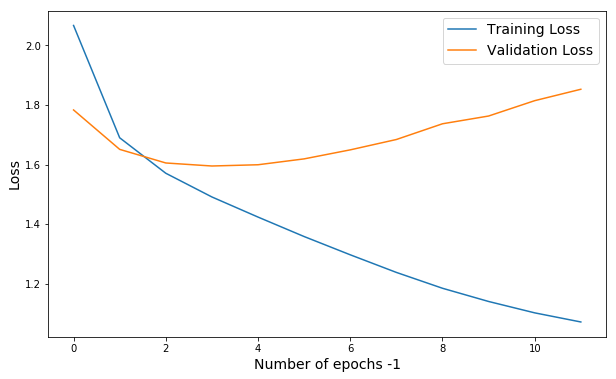

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(history3.history['loss'],label='Training Loss')
plt.plot(history3.history['val_loss'],label='Validation Loss')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.legend(loc="upper right", fontsize=14)

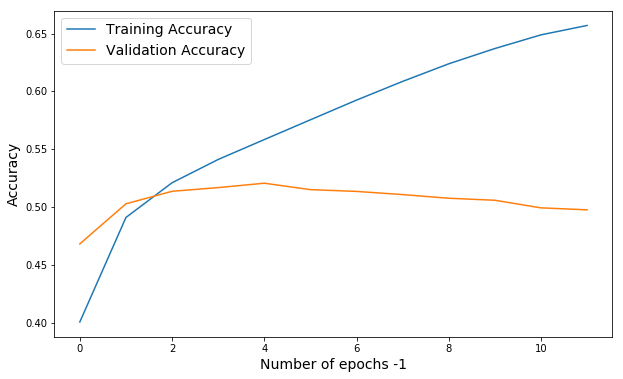

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(history3.history['acc'],label='Training Accuracy')
plt.plot(history3.history['val_acc'],label='Validation Accuracy')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.legend(loc="upper left", fontsize=14)

In [68]:
n_snippet=100
prompt = "With this "
predicted_text = prompt
prompt_int = np.array([idxGivenChar[c] for c in predicted_text])
start_char_int = len(prompt_int)
input_example_batch=np.zeros([batch_size,snippet_length-1],np.int32)
for snippet in range(n_snippets):
    input_example_batch[0,:start_char_int] = prompt_int #we start with char_int = 10 with a prompt of 10 char
    for char_idx in range(start_char_int, snippet_length): # char_idx starts at 10 and ends at 20: 11 numbers
        example_batch_predictions = np.argmax(model3.predict([input_example_batch[:,:seq_length],
                                                              input_example_batch[:,seq_length:]],
                                                              verbose=0,batch_size=batch_size),axis=2)
        predicted_char = example_batch_predictions[0,char_idx-1] #predicted char starts at 0 ends at 10: 11 numbers
        predicted_text = predicted_text + charGivenIdx[predicted_char]
        if char_idx <snippet_length-1: #if char_idx is less than 20
            input_example_batch[0,char_idx]= predicted_char
        else: # if char_idx is 20, drop first character of the prompt; 
            prompt_int[:start_char_int-1] = input_example_batch[0,snippet_length-start_char_int:snippet_length-1]
            prompt_int[start_char_int-1] = predicted_char

In [69]:
print(predicted_text)

With this on the housease.

LUCIO:
Within the day in companies and so fair a thoughts,
And to the constard
To be my husband; and, will you to the people the priest
Tellest that made me say in this marriage?

POLIXENES:
O, go you the prison. Well, sir, then I were all his own purpose, whose person in plain.

ROMEO:
Whither?

GLOUCESTER:
I talk not what you please you, sir, an you, will you come to your honour! O me!
What makis me?

DUKE VINCENTIO:
I will protesy you.

PETRUCHIO:
Father, be gone to Rome, and a parloon.

Messenger:
Say you have been abused her beggary which will be gone.

LADY CAPULET:
Who are of the duke to be spender-by their masters come to make me not to me, and stay with thee word and be such a devility,
I will confess you do it.

GREMIO:
Ahat, march word is such a man of a kingdom
To this prince to the searmorror of thy soul stings.

KING EDWARD IV:
Say is the barth to me this armed burning stone.

CORIOLANUS:
Most pardon, pardon, doth grace! and so I do death;
But 

Of course this is English too. This time, and for the next model, we will not bother with the curves.

However, the last two models only use short prompts. This does not leave people much lee-way to express anything in it.

#### Model iteration 4: the encoder is made of a stack of GRUs

So, this next iteration uses a hiearchical encoder: a sequence of 40 characters is fed to 4 GRU units, each handling 10 and each starting with a vector of zeros as their initial state, to avoid backpropagating gradients further downstream. The output of these 4 GRUs is a set of four vectors, itself fed to another GRU. The later outputs the latent vector for the decoder and attempts to predict the first decoded character.

In order to simplify the model we need a custom keras layer to split a sequence of 40 characters into 4 sets of 10. This way we do not need 4 separate sets of embedding weights. This is the purpose of the class below.

In [70]:
class MySplitLayerVersion(tf.keras.layers.Layer):
    def __init__(self,n_splits):
        super().__init__()
        self.n_splits=n_splits
        
    def call(self,inputs):
        return tf.split(inputs,num_or_size_splits=self.n_splits,axis=1)

In [71]:
encoder_seq_inputs=tf.keras.Input(batch_shape=(batch_size,4*seq_length))
# batch_size by 40
decoder_seq_inputs=tf.keras.Input(batch_shape=(batch_size,seq_length))
# batch_size by 10
x0=tf.keras.layers.Embedding(vocab_size,embedding_dim,batch_size=batch_size)(encoder_seq_inputs)
# batch_size by 40 by embedding dim
x1,x2,x3,x4=MySplitLayerVersion(4)(x0)
# each: batch_size by 10 by embdding dim
x1a=tf.keras.layers.GRU(rnn_units,return_sequences=False,return_state=False,stateful=False,
                                               recurrent_initializer='glorot_uniform')(x1)
x1b=tf.keras.layers.Reshape(target_shape=(1,rnn_units))(x1a)
x2a=tf.keras.layers.GRU(rnn_units,return_sequences=False,return_state=False,stateful=False,
                                               recurrent_initializer='glorot_uniform')(x2)
x2b=tf.keras.layers.Reshape(target_shape=(1,rnn_units))(x2a)
x3a=tf.keras.layers.GRU(rnn_units,return_sequences=False,return_state=False,stateful=False,
                                               recurrent_initializer='glorot_uniform')(x3)
x3b=tf.keras.layers.Reshape(target_shape=(1,rnn_units))(x3a)
x4a=tf.keras.layers.GRU(rnn_units,return_sequences=False,return_state=False,stateful=False,
                                               recurrent_initializer='glorot_uniform')(x4)
x4b=tf.keras.layers.Reshape(target_shape=(1,rnn_units))(x4a)
x5=tf.keras.layers.Concatenate(axis=1)([x1b,x2b,x3b,x4b])
x5a=tf.keras.layers.GRU(rnn_units,return_sequences=False,return_state=False,stateful=False,
                                               recurrent_initializer='glorot_uniform')(x5)
x6=tf.keras.layers.Embedding(vocab_size,embedding_dim,batch_size=batch_size)(decoder_seq_inputs)
# batch_size by 50 by embedding dim
x7=tf.keras.layers.GRU(rnn_units,return_sequences=True,stateful=False,
                                               recurrent_initializer='glorot_uniform')([x6,x5a])
x5b=tf.keras.layers.Reshape(target_shape=(1,rnn_units))(x5a)
x8=tf.keras.layers.Concatenate(axis=1)([x5b,x7])
outputs=tf.keras.layers.Dense(vocab_size, activation ='softmax')(x8)
model4=tf.keras.Model(inputs=[encoder_seq_inputs,decoder_seq_inputs],outputs=outputs)
model4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (64, 40)             0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (64, 40, 256)        16640       input_9[0][0]                    
__________________________________________________________________________________________________
my_split_layer_version_1 (MySpl [(64, 10, 256), (64, 0           embedding_9[0][0]                
__________________________________________________________________________________________________
gru_7 (GRU)                     (64, 1024)           3935232     my_split_layer_version_1[0][0]   
__________________________________________________________________________________________________
gru_8 (GRU

In [72]:
model4.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['acc'])

In [73]:
snippet_length=5*seq_length+1
n_samples_per_epoch = len(text)//snippet_length
print(n_samples_per_epoch)

21870


In [74]:
sequences = np.array([text_as_int[idx*snippet_length:(idx+1)*snippet_length] for idx in range(n_samples_per_epoch)])
print(sequences.shape)
n_batches_per_epoch=n_samples_per_epoch//batch_size
print(n_batches_per_epoch)

(21870, 51)
341


In [75]:
n_usable_samples=n_batches_per_epoch*batch_size
print(n_usable_samples)

21824


In [76]:
def split_input_target2(snippet):
    input_text = snippet[:,:5*seq_length]
    target_text = snippet[:,4*seq_length:]
    return input_text, target_text

input_data, target_data = split_input_target2(sequences[:n_usable_samples])
print(input_data.shape, target_data.shape)

(21824, 50) (21824, 11)


In [77]:
n_batches_per_epoch//10
validation_split=(n_batches_per_epoch//10)/n_batches_per_epoch
print(validation_split)

0.09970674486803519


In [78]:
history4=model4.fit([input_data[:,:4*seq_length],input_data[:,4*seq_length:]],
                    keras.utils.to_categorical(target_data, num_classes=vocab_size),
                    shuffle=True, validation_split=validation_split,
                    batch_size=batch_size, epochs=10) #10

Train on 19648 samples, validate on 2176 samples
Epoch 1/10
19648/19648 [==============================] - 68s 3ms/step - loss: 2.3257 - acc: 0.3454 - val_loss: 2.0389 - val_acc: 0.4029
Epoch 2/10
19648/19648 [==============================] - 65s 3ms/step - loss: 1.8513 - acc: 0.4534 - val_loss: 1.8952 - val_acc: 0.4392
Epoch 3/10
19648/19648 [==============================] - 65s 3ms/step - loss: 1.6645 - acc: 0.5005 - val_loss: 1.8125 - val_acc: 0.4666
Epoch 4/10
19648/19648 [==============================] - 65s 3ms/step - loss: 1.5252 - acc: 0.5368 - val_loss: 1.7854 - val_acc: 0.4841
Epoch 5/10
19648/19648 [==============================] - 65s 3ms/step - loss: 1.3903 - acc: 0.5703 - val_loss: 1.8108 - val_acc: 0.4765
Epoch 6/10
19648/19648 [==============================] - 65s 3ms/step - loss: 1.2412 - acc: 0.6122 - val_loss: 1.8576 - val_acc: 0.4825
Epoch 7/10
19648/19648 [==============================] - 65s 3ms/step - loss: 1.0746 - acc: 0.6607 - val_loss: 1.9807 - val_acc:

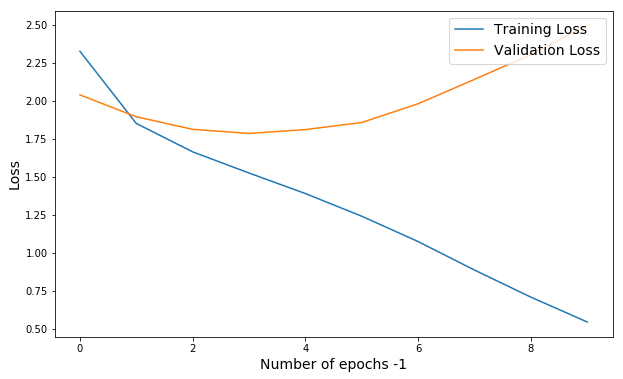

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(history4.history['loss'],label='Training Loss')
plt.plot(history4.history['val_loss'],label='Validation Loss')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.legend(loc="upper right", fontsize=14)

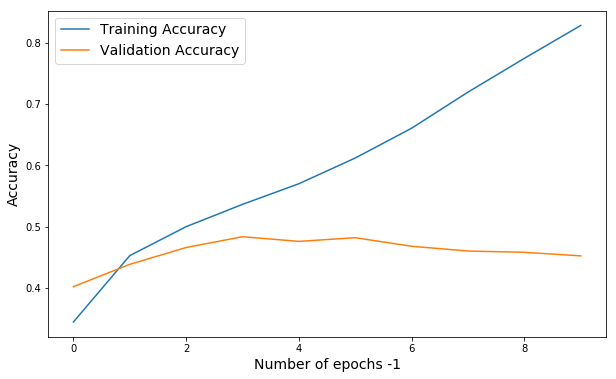

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(history4.history['acc'],label='Training Accuracy')
plt.plot(history4.history['val_acc'],label='Validation Accuracy')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.legend(loc="upper left", fontsize=14)

In [81]:
n_snippet=5
prompt = "I did not want to write this poem, so I "
predicted_text = prompt
prompt_int = np.array([idxGivenChar[c] for c in predicted_text])
start_char_int = len(prompt_int)
input_example_batch=np.zeros([batch_size,snippet_length-1],np.int32)
for snippet in range(n_snippets):
    input_example_batch[0,:start_char_int] = prompt_int #we start with char_int = 40 with a prompt of 40 char
    for char_idx in range(start_char_int, snippet_length): # char_idx starts at 40 and ends at 50: 11 numbers
        example_batch_predictions = np.argmax(model4.predict([input_example_batch[:,:4*seq_length],
                                                              input_example_batch[:,4*seq_length:]],
                                                              verbose=0,batch_size=batch_size),axis=2)
        predicted_char = example_batch_predictions[0,char_idx-4*seq_length] #predicted char starts at 0 ends at 10: 11 numbers
        predicted_text = predicted_text + charGivenIdx[predicted_char]
        if char_idx <snippet_length-1: #if char_idx is less than 50
            input_example_batch[0,char_idx]= predicted_char
        else: # if char_idx is 20, drop first character of the prompt; 
            prompt_int[:start_char_int-1] = input_example_batch[0,snippet_length-start_char_int:snippet_length-1]
            prompt_int[start_char_int-1] = predicted_char

In [82]:
print(predicted_text)

I did not want to write this poem, so I trow thy herm.

Second Seepher:
No, no, no, my lord, to make me with a long,
And therefore fastises of her no might souls,
Save his race his fathers of the success,
And therefore friends, so he dis face. Phat take
his heart as driams to lies me as ore
I no fortune, my lord, to rate her before.

Second Citizens:
You are never with me, in her appears,
After thou some is cruncess this other before
As sleep in the drume on her nought so villain
Which rest underselves make him state; and answer
To thee, bet me not again to alse to look
And with his house of true reportuness
As so fellow withis and as no king:
Ay, I am no endes to pleased my county.

QUEEN Murderer:
Now, fair beful in the native provies a drum,
Sace dispainsaying in his heart,
And then I'll say in while you with a fribe.

LEONTES:
And then, my lord should not bise my life,
Shall have a shame. Why counsel some stroke
This sun fall'd wish with our counsel,
Who come on in princes, the oun

## Step 4: Results

To summarize, the results below show using 1 D convolutions on the sequence demension does not lead to accurate prediction of the decoder initial state. This is likely because convolutions render the detection of a feature invariant to position. In language, position matters as syllable order matters. 

Using GRUs in the encoder, with or without the return_sequences parameter set to True produces good results. This confirms, as Andrej Karpathy implied that GRUs are a good way to encode sequences such as language.

However, we get the best results with a hierarchical encoder, a deeper one, because it allows for a longer prompt. Because the stateful parameter of each of the bottom GRUs of the encoder is set to False, gradients cannot propagate further down. Its output is also English.

As for validation accuracy, it is a poor measure of performance

In [123]:
index_list=['CNN encoder','GRU encoder with last state output','GRU with sequences ouput','Stacked GRUs']
column_list=['Validation Accuracy','English?']
y='yes'
n='no'
values=[[history1.history['val_acc'][-1],n],[history2.history['val_acc'][-1],y],
        [history3.history['val_acc'][-1],y],[history4.history['val_acc'][-1],y]]
table_df=pd.DataFrame(values,index=index_list,columns=column_list)
table_df.head()

,Validation Accuracy,English?
CNN encoder,0.924993,no
GRU encoder with last state output,0.490663,yes
GRU with sequences ouput,0.497609,yes
Stacked GRUs,0.452958,yes


## Step 5: Conclusion

Using a classical encoder decoder model with GRU units, it is possible to generate quite a long Shakesperian text without infinitely backpropagating the gradients, which only go back to the first character of the encoder. This usually means short prompts.

But short prompts do not give much opportunity to my brother in law to give cues about himself, when writing his Christmas poem.

A solution to this conendrum is to build a deeper, hierarchical encoder: the prompt is a bit longer.

Maybe my brother-in-law shoud write his poems anyway: sometimes, when you feed the networ the prompt: "If this poem was not", it answers:

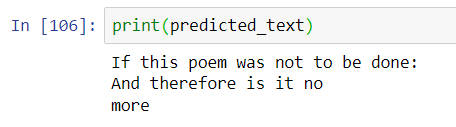

#### Bibliography

[1] Tensorflow authors. Text generation with an RNN. Tensorflow tutorial
https://www.tensorflow.org/text/tutorials/text_generation

[2] Kyunghyun Cho, Bart van Merrienboer, Caglar Gulcehre, Fethi Bougares, Holger Schwenk, Yoshua Bengio (2014). Learning Phase Representations using RNN Encoder-Decoder for Statistical Machine Translation. arXiv:1406.1078v1

[3] Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin (2017). Attention is all you need. 31st Conference on Neural Information Processing Systems (NIPS 2017), Long Beach, CA, USA.
arXiv:1706:03762v5

[4] Andrej Karpathy (2015). The Unreasonable Effectiveness of Recurrent Neural Networks. Andrej Karpathy blog
https://karpathy.github.io/2015/05/21/rnn-effectiveness/